## Laboratorio 5 :  Principio de Pontryagin & Ecuaciones de HJB.

#### Integrantes:
Diego Olguín
Maximiliano Lioi

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sympy
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from scipy.optimize import fsolve
from scipy.interpolate import interp1d

### Parte A. Métodos numéricos basados en Pontryagin

Consideramos el siguiente sistema dinámico para los camarones junto al problema de extracción de manera con el fin de mantener a futuro el negocio de pesca.

$\left\{\begin{aligned} \max & \int_0^{t_f} C(t) \cdot\left(C A(t) \cdot m_a+C C(t) \cdot m_c\right) d t \\ & \frac{d}{d t} C A(t)=A \cdot \zeta(t-d) \cdot C C(t)-(M+C(t)) \cdot C A(t) \\ \text { sa. } \frac{d}{d t} C C(t) & =-A \cdot \zeta(t-d) \cdot C C(t)-(M+C(t)) \cdot C C(t)+N \cdot \zeta(t) \cdot C A(t) \\ & C(t) \in\left[0, C_{\max }\right] \quad \forall t \in\left[0, t_f\right]\end{aligned}\right.$

Donde, las variables dependientes del tiempo son:
- CA(t): la cantidad de camarones adultos en un determinado momento.
- CC(t): la cantidad de crı́as de camarones en un determinado momento.
- C(t) : la intensidad de captura en un instante de tiempo (el control).

Y donde $\zeta(t) = 1 + sin(\frac{2 \pi t}{c})$

In [ ]:
# Constantes del problema
tf, Cmax, ma, mc, A, N, M, c, d = 52, 1, 0.02, 0.005, 0.5, 0.85, 0.35, 12, 4
args = tf, Cmax, ma, mc, A, N, M, c, d

CA0, CC0 = 3000, 1000

zeta = lambda t: 1 + np.sin(2*np.pi*t/c)

#### Ejercicio 1

Se utiliza el Principio del Máximo de Pontryaguin para encontrar la dinámica de los estados
adjuntos $p = (p_1 , p_2 )$, las condiciones de transversalidad, y una caracterización del control óptimo.

Para ello consideramos el Hamiltoniano del sistema 
$$H(CA,CC,C,p_1,p_2,t) = -C(CA m_a + CC m_c) + p_1(A \zeta(t-d) CC - (M+C)CA) + p_2(-A \zeta(t-d)CC - (M+C)CC + N \zeta(t)CA)$$

Donde $l(CA,CC,C,p_1,p_2,t) = -C(CA m_a + CC m_c)$

Se deduce que el estado adjunto $\dot{p} = -\partial_x H$ tiene la siguiente estructura

$$
\begin{bmatrix} 
\dot{p_1}(t) \\
\dot{p_2}(t) \end{bmatrix} = 
- \begin{bmatrix} 
-C(t) m_a - p_1(t)(M+C(t)) + p_2(t)N\zeta(t)\\
-C(t) m_c + p_1(t) A \zeta(t-d) + p_2(-(M+C(t)) - A \zeta(t-d))) \end{bmatrix} 
$$

Puesto que el problema es de tipo Lagrangeano se deducen las condiciones de transversalidad

- $p_0  = 1$
- $p(t_f) = 0$

Para caracterizar el control óptimo hacemos uso del principio de mínimo de Pontryaguin

$$
u(t) \in \arg \min_{w \in [0,C_{max}]} H(CA(t),CC(t), w, p_1(t), p_2(t), t)
$$

$$ \iff u(t) \in \arg \min_{w \in [0,C_{max}]} -C(CA m_a + CC m_c) + p_1(A \zeta(t-d) CC - (M+C)CA) + p_2(-A \zeta(t-d)CC - (M+C)CC + N \zeta(t)CA)$$

Es equivalente a

$$
\iff u(t) \in \arg \min_{C \in [0,C_{max}]} -C(CA(t) m_a + CC(t) m_c) - p_1(M+C(t))CA(t) - p_2(M+C(t))CC(t)
$$

$$
\iff u(t) \in \arg \min_{C \in [0,C_{max}]} C(-CA(t)m_a - CC(t)m_c - p_1(t)CA(t) - p_2(t)CC(t))
$$

$$ 
\implies u(t) = C_{max} * \mathbf{1}[-CA(t)m_a - CC(t)m_c - p_1(t)CA(t) - p_2(t)CC(t) \leq 0]
$$

De donde obtenemos una caracterización para el control óptimo $u(t)$

#### Ejercicio 2
Se crea una función que le permite calcular el control óptimo en un determinado instante, en función de $CA, CC, p,  t$ haciendo uso de la caracterización anterior

In [ ]:
def C_fun(CC, CA, p1, p2, t):
    return Cmax*(-CA*ma-CC*mc-p1*CA-p2*CC <= 0)

#### Ejercicio 3

Se implementa el sistema dinámico acoplado $(CC, CA, p_1 , p_2 )$ sin considerar las condiciones de transversalidad, haciendo uso de la caracterización anterior para el control en función de los estados de este sistema

$\textbf{Dinámica:}$
$$
\begin{bmatrix}
\dot{CA}(t) \\
\dot{CC}(t) \\
\dot{p_1}(t) \\
\dot{p_2}(t)
\end{bmatrix}
=
\begin{bmatrix}
A \cdot \zeta(t-d) \cdot CC(t) - (M+C(t)) \cdot CA(t) \\
-A \cdot \zeta(t-d) \cdot CC(t) - (M+C(t)) \cdot CC(t) + N \cdot \zeta(t) \cdot CA(t) \\
-(-C(t) \cdot m_a - p_1 \cdot (M+C(t)) + p_2 \cdot N \cdot \zeta(t)) \\
-(-C \cdot m_c + p_1 \cdot A \cdot \zeta(t-d) + p_2 \cdot (-(M+C(t)) - A \cdot \zeta(t-d)))
\end{bmatrix}
$$

In [ ]:
def F(t, X, args):
    CA, CC, p1, p2 = X
    C = C_fun(CC, CA, p1, p2, t)
    
    dCA = A*zeta(t-d)*CC - (M+C)*CA
    dCC = -A*zeta(t-d)*CC - (M+C)*CC + N*zeta(t)*CA 
    dp1 = -(-C*ma - p1*(M+C) + p2*N*zeta(t))
    dp2 = -(-C*mc + p1*A*zeta(t-d) + p2*(-(M+C)-A*zeta(t-d))) 

    return np.array([dCA, dCC, dp1, dp2])

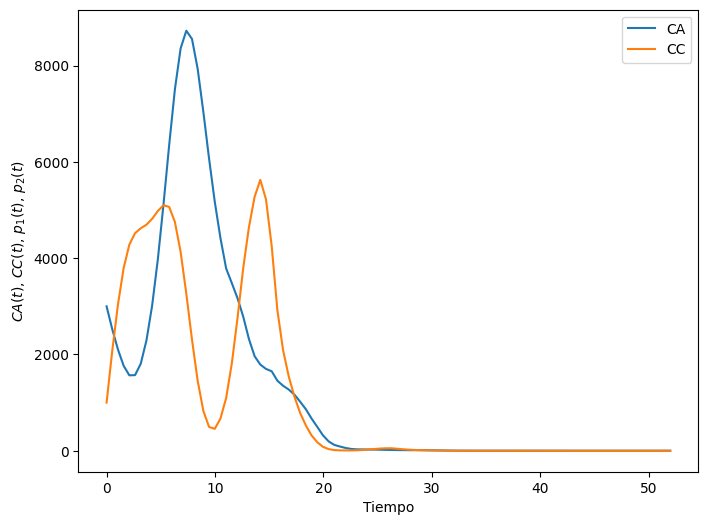

In [ ]:
nt = 100
t_eval = np.linspace(0, tf, nt) 
p10, p20 = -10,-2 # Condiciones iniciales para probar el código
X0 = np.array([CA0, CC0, p10, p20])

res = solve_ivp(F, (0, tf), X0, t_eval=t_eval, args=(args,))

X = res["y"]

CA, CC, p1, p2 = X 

plt.figure(figsize=(8, 6))
plt.plot(t_eval, CA, label="CA")
plt.plot(t_eval, CC, label="CC")
#plt.plot(t_eval, p1, label=r"$p_1$")
#plt.plot(t_eval, p2, label=r"$p_2$")
plt.legend()
plt.xlabel("Tiempo")
plt.ylabel(r"$CA(t)$, $CC(t)$, $p_1(t)$, $p_2(t)$ ")
plt.show()

#### Ejercicio 4: Método de tiro

Se utilizan las condiciones de transversalidad y la parte anterior, para determinar el control óptimo del sistema.

Para ello buscamos los valores $(p_1(0),p_2(0))$ asociados a la solución de la dinámica $(CA, CC, p_1 , p_2)$ sujeta a las condiciones de transversalidad $(p_1(t_f), p_2(t_f)) = (0,0)$ mediante el método de tiro, para ello se hace uso del método \textit{fsolve} considerando las funciones 
$$
f(x) = p_1(t_f) \ , \ g(x) = p_2(t_f)
$$
Donde $(p_1(t),p_2(t))$ las soluciones de la dinámica y $x = (p_1(0),p_2(0)) \in \mathbb{R}^{2}$
$$
\dot{X}(t) = f(t,X(t)) \ \ X(0) = \begin{bmatrix} 
CA(0) \\
CC(0) \\
p_1(0)\\
p_2(0)
\end{bmatrix}
$$
Y donde
$$
\dot{X}(t)
=
\begin{bmatrix}
\dot{CA}(t) \\
\dot{CC}(t) \\
\dot{p_1}(t) \\
\dot{p_2}(t)
\end{bmatrix} \ , \ 
f(t,X(t))
=
\begin{bmatrix}
A \cdot \zeta(t-d) \cdot CC(t) - (M+C(t)) \cdot CA(t) \\
-A \cdot \zeta(t-d) \cdot CC(t) - (M+C(t)) \cdot CC(t) + N \cdot \zeta(t) \cdot CA(t) \\
-(-C(t) \cdot m_a - p_1 \cdot (M+C(t)) + p_2 \cdot N \cdot \zeta(t)) \\
-(-C \cdot m_c + p_1 \cdot A \cdot \zeta(t-d) + p_2 \cdot (-(M+C(t)) - A \cdot \zeta(t-d)))
\end{bmatrix}
$$

Por lo que se resuelve en \textit{fsolve} el sistema de ecuaciones

$$
\begin{cases}
    f(x) = 0 \\
    g(x) = 0
\end{cases},  \ \ x = (p_1(0),p_2(0)) \in \mathbb{R}^{2}
$$

In [ ]:
# Método de tiro
# Entrega valores de p_1(tf) y p_2(tf) para la condición inicial x = (p_1(0) y p_2(0))
def shooting(x):
    p10, p20 = x
    X0 = np.array([CA0, CC0, p10, p20])
    res = solve_ivp(F, (0, tf), X0, args=(args,))
    X = res["y"]
    CA, CC, p1, p2 = X 

    return [
        p1[-1],
        p2[-1]
    ]

In [ ]:
# Entrega (p_1(0), p_2(0)) que resuelve el sistema de ecuaciones
res_sol = fsolve(shooting, x0=[-10,-10], epsfcn=1e-21, full_output=True)

Resuelto el sistema de ecuaciones se procede a computar la dinámica $(CA,CC,p_1,p_2)$ con condiciones iniciales definidas por los valores de $p_1(0)$ y $p_2(0)$ encontrados mediante el método de tiro.

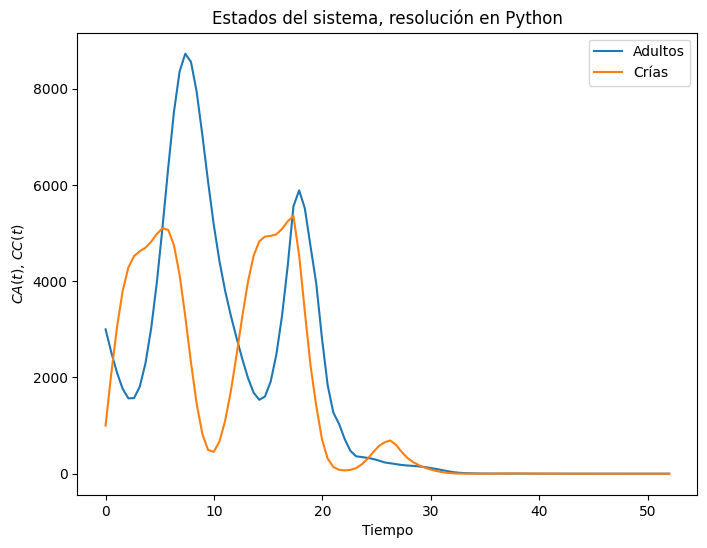

In [ ]:
# Inicialización
nt = 100
t_eval = np.linspace(0, tf, nt) 
p10, p20 = res_sol[0] 
X0 = np.array([CA0, CC0, p10, p20])

# Resuelve dinámica
res = solve_ivp(F, (0, tf), X0, t_eval=t_eval, args=(args,))

X = res["y"]
CA, CC, p1, p2 = X 

# Gráficos
plt.figure(figsize=(8, 6))
plt.plot(t_eval, CA, label="Adultos")
plt.plot(t_eval, CC, label="Crías")
plt.legend()
plt.xlabel("Tiempo")
plt.ylabel(r"$CA(t)$, $CC(t)$")
plt.title("Estados del sistema, resolución en Python")
plt.show()

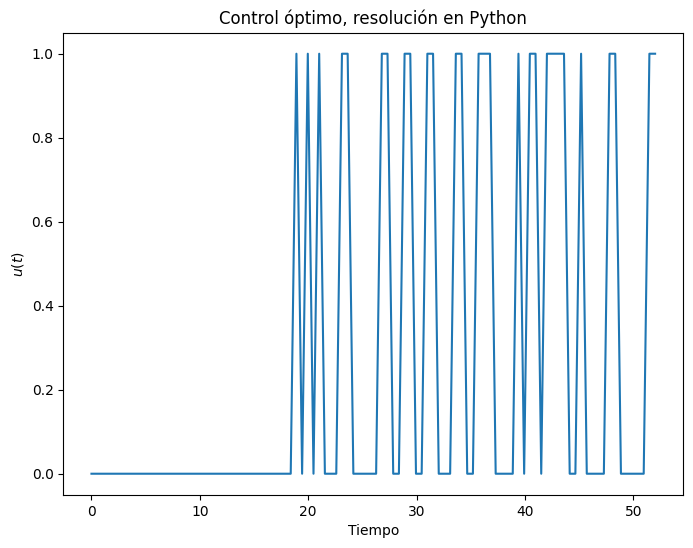

In [ ]:
# Entrega el control óptimo conocidos los estados óptimos (CC,CA,p1,p2)
co_op = C_fun(CC, CA, p1, p2, t_eval)

# Gráficos
plt.figure(figsize=(8, 6))
plt.plot(t_eval, co_op)
plt.xlabel("Tiempo")
plt.ylabel(r"$u(t)$")
plt.title("Control óptimo, resolución en Python")
plt.show()

#### Ejercicio 5
El objetivo de este ejercicio es implementar el problema en BOCOP y obtener una solución con este software. Para ello se convierte el problema Lagrange en uno Mayer como sigue. Sea 
  
Entonces $z$ satisface
$$
    \dot z (t) = C(t) (CA(t) m_a + CC(t)m_c); \quad z(0) = 0
$$
Por lo que el problema queda 

$$
\left\{\begin{aligned} \min & -z(t_f) \\ & \frac{d}{d t} C A(t)=A \cdot \zeta(t-d) \cdot C C(t)-(M+C(t)) \cdot C A(t) \\ \text { sa. } \frac{d}{d t} C C(t) & =-A \cdot \zeta(t-d) \cdot C C(t)-(M+C(t)) \cdot C C(t)+N \cdot \zeta(t) \cdot C A(t) \\ & C(t) \in\left[0, C_{\max }\right] \quad \forall t \in\left[0, t_f\right]\end{aligned}\right.
$$
Así se puede introducir el problema a BOCOP. Se utilizaron 100 pasos de tiempo y el método Gauss II (implícito, 2 etapas, orden 4). 
Los gráficos obtenidos son los siguientes

**Importe**

In [ ]:
CA_bocop = np.array([
    3000,
    2526.57,
    2111.21,
    1773.59,
    1571.31,
    1563.74,
    1786.06,
    2248.24,
    2948.74,
    3878.08,
    5000.25,
    6222.77,
    7382.2,
    8270.9,
    8707.27,
    8614.62,
    8056.03,
    7199.87,
    6241.92,
    5334.88,
    4557.46,
    3920.67,
    3392.71,
    2927.61,
    2492.02,
    2086.48,
    1752.38,
    1556.7,
    1561.43,
    1801.11,
    2284.63,
    3010.73,
    3972.38,
    5137.27,
    6415.65,
    7642.69,
    8602.85,
    9100.91,
    9046.02,
    8493.41,
    7613.54,
    6612.18,
    5654.46,
    4828.88,
    4151.62,
    3591.78,
    3101.33,
    2643.41,
    2215.35,
    1857.47,
    1638.87,
    1625.97,
    1857.43,
    2344.03,
    3084.85,
    4073.39,
    5279.05,
    6613.53,
    7910.08,
    8944.97,
    7323.9,
    4346.21,
    4097.09,
    3683.88,
    3205.27,
    2742.73,
    2341.61,
    2011.95,
    1740.17,
    1503.39,
    1283.08,
    1076.44,
    901.29,
    790.17,
    775.547,
    877.13,
    1100.87,
    1446.52,
    1911.33,
    2482.08,
    3119.1,
    3745.36,
    3278.64,
    2081.07,
    1241.15,
    698.513,
    374.635,
    194.214,
    98.9011,
    50.2027,
    25.6357,
    13.181,
    6.77463,
    3.44245,
    1.71932,
    0.855121,
    0.443163,
    0.255876,
    0.170254,
    0.12626,
    0.0984341
])

In [ ]:
CC_bocop = np.array([
    1000,
    2070.02,
    3022.42,
    3774.34,
    4266.55,
    4516.85,
    4619.55,
    4691.32,
    4807.14,
    4966.39,
    5096.11,
    5080.45,
    4808.6,
    4230.95,
    3398.1,
    2453.38,
    1576.28,
    912.126,
    532.459,
    441.194,
    607.143,
    993.29,
    1565.58,
    2280.93,
    3067.1,
    3815.86,
    4408.67,
    4770.81,
    4916.04,
    4939.32,
    4957.93,
    5045.2,
    5196.45,
    5332.73,
    5330.25,
    5068.37,
    4487.43,
    3631.51,
    2644.67,
    1714.63,
    998.382,
    577.082,
    459.217,
    613.668,
    1001.51,
    1587.06,
    2326.7,
    3147.73,
    3939.27,
    4576.24,
    4974.78,
    5141.58,
    5171.24,
    5187.46,
    5272.37,
    5427.65,
    5575.82,
    5589.29,
    5339.38,
    4756.7,
    2979.26,
    1303.12,
    852.667,
    499.849,
    286.674,
    219.45,
    284.116,
    461.976,
    735.896,
    1085.62,
    1477.7,
    1860.24,
    2173.01,
    2373.27,
    2460.54,
    2477.65,
    2484.1,
    2521.7,
    2594.4,
    2667.64,
    2681.42,
    2573.1,
    1772.88,
    866.964,
    382.201,
    150.185,
    52.8017,
    17.9354,
    7.86872,
    5.83709,
    5.6024,
    5.32826,
    4.7019,
    3.82848,
    2.88263,
    2.01332,
    1.31366,
    0.812527,
    0.487203,
    0.290369,
    0.175074
])

In [ ]:
value_bocop = np.array([
    0,
    -3.26899e-007,
    -6.34107e-007,
    -9.24108e-007,
    -1.2017e-006,
    -1.47746e-006,
    -1.76854e-006,
    -2.09724e-006,
    -2.48879e-006,
    -2.96891e-006,
    -3.56019e-006,
    -4.27626e-006,
    -5.11434e-006,
    -6.04971e-006,
    -7.03665e-006,
    -8.01804e-006,
    -8.94039e-006,
    -9.76718e-006,
    -1.04844e-005,
    -1.10975e-005,
    -1.16238e-005,
    -1.20839e-005,
    -1.24963e-005,
    -1.28744e-005,
    -1.32255e-005,
    -1.35529e-005,
    -1.3859e-005,
    -1.41494e-005,
    -1.4436e-005,
    -1.4737e-005,
    -1.50759e-005,
    -1.5479e-005,
    -1.59732e-005,
    -1.65825e-005,
    -1.73219e-005,
    -1.81901e-005,
    -1.91631e-005,
    -2.01943e-005,
    -2.12244e-005,
    -2.21965e-005,
    -2.30707e-005,
    -2.38304e-005,
    -2.44803e-005,
    -2.50375e-005,
    -2.55238e-005,
    -2.59589e-005,
    -2.63571e-005,
    -2.67268e-005,
    -2.70714e-005,
    -2.73934e-005,
    -2.76984e-005,
    -2.79982e-005,
    -2.83113e-005,
    -2.86621e-005,
    -2.9078e-005,
    -2.95872e-005,
    -3.02151e-005,
    -3.09786e-005,
    -3.18778e-005,
    -3.28895e-005,
    48.1144,
    113.076,
    113.076,
    113.076,
    113.076,
    113.076,
    113.076,
    113.076,
    113.076,
    113.076,
    113.076,
    113.076,
    113.076,
    113.076,
    113.076,
    113.076,
    113.076,
    113.076,
    113.076,
    113.076,
    113.076,
    113.076,
    134.931,
    165.793,
    184.333,
    194.846,
    200.515,
    203.46,
    204.96,
    205.724,
    206.118,
    206.327,
    206.441,
    206.503,
    206.537,
    206.557,
    206.567,
    206.574,
    206.577,
    206.58,
    206.582
])

In [ ]:
# Inicialización
t_bocop = np.linspace(0, tf, len(CA_bocop))
h = t_eval[1] - t_eval[0]

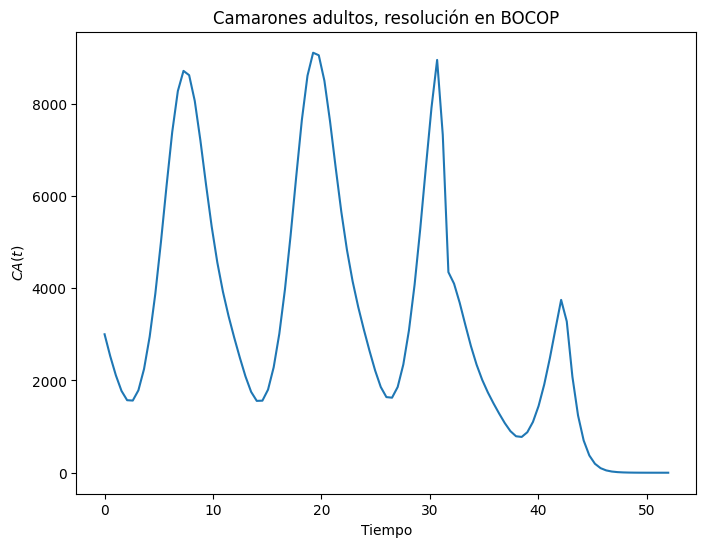

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(t_bocop, CA_bocop, label="Adultos")
plt.xlabel("Tiempo")
plt.ylabel(r"$CA(t)$")
plt.title("Camarones adultos, resolución en BOCOP")
plt.show()

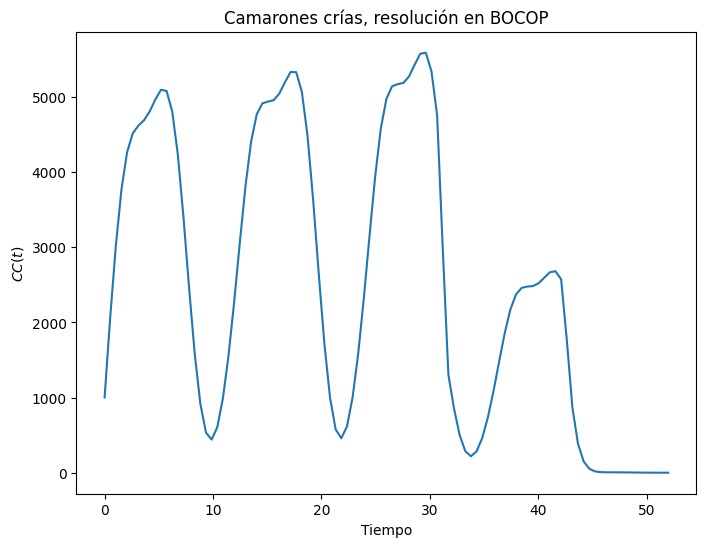

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(t_bocop, CC_bocop, label="Crías")
plt.xlabel("Tiempo")
plt.ylabel(r"$CC(t)$")
plt.title("Camarones crías, resolución en BOCOP")
plt.show()

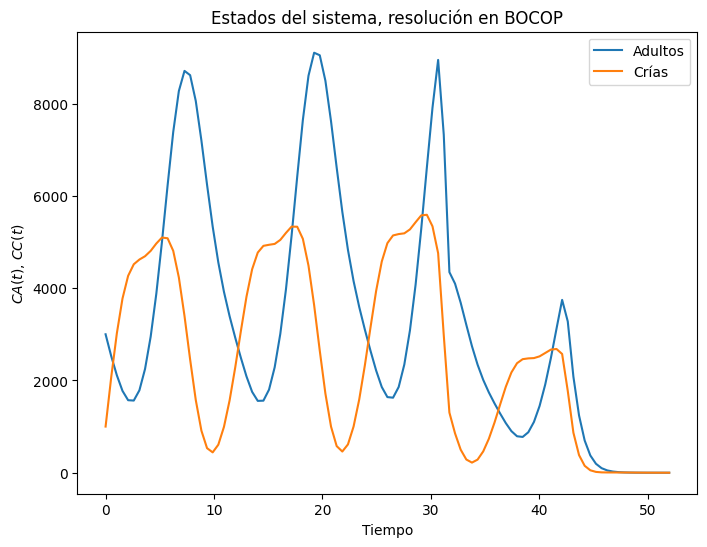

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(t_bocop, CA_bocop, label="Adultos")
plt.plot(t_bocop, CC_bocop, label="Crías")
plt.legend()
plt.xlabel("Tiempo")
plt.ylabel(r"$CA(t)$, $CC(t)$")
plt.title("Estados del sistema, resolución en BOCOP")
plt.show()

#### Ejercicio 6

Compare ambos métodos, mostrando lado a lado, el control, la evolución de las variables de estado
y la función de optimización. Compare además el valor objetivo obtenido en cada caso, estime errores y comente
acerca del tiempo de ejecución

Una vez hecho todo lo anterior ¿Cuál de los controles utilizaría para resolver este problema en la vida real? ¿Por
qué? ¿Y si fuera otro problema, bajo qué criterios escogería uno o el otro?

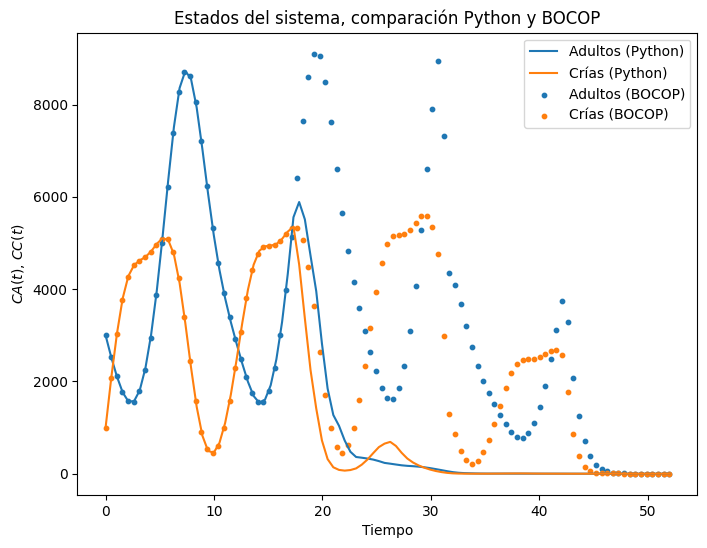

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(t_eval, CA, label="Adultos (Python)")
plt.plot(t_eval, CC, label="Crías (Python)")
plt.scatter(t_bocop, CA_bocop, s=10, label="Adultos (BOCOP)")
plt.scatter(t_bocop, CC_bocop, s=10, label="Crías (BOCOP)")
plt.legend()
plt.xlabel("Tiempo")
plt.ylabel(r"$CA(t)$, $CC(t)$")
plt.title("Estados del sistema, comparación Python y BOCOP")
plt.show()

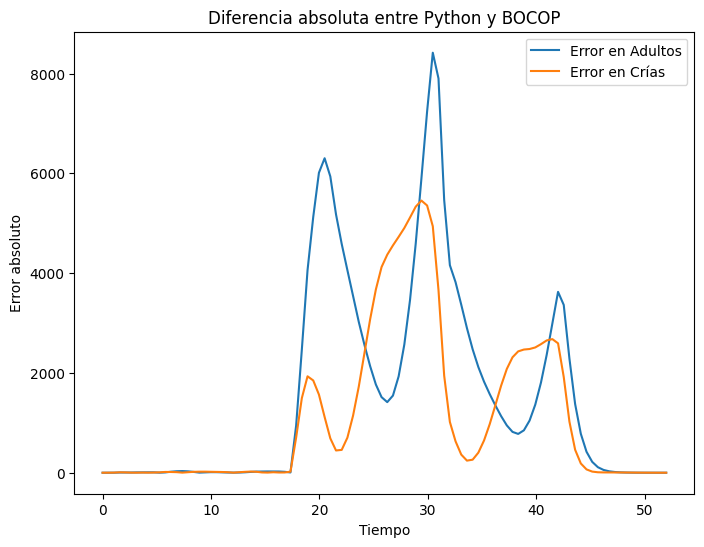

In [ ]:
CA_py_int = interp1d(t_eval, CA)
CA_boc_int = interp1d(t_bocop, CA_bocop)
CC_py_int = interp1d(t_eval, CC)
CC_boc_int = interp1d(t_bocop, CC_bocop)

error_a_CA = np.abs(CA_py_int(t_eval) - CA_boc_int(t_eval)) 
error_a_CC = np.abs(CC_py_int(t_eval) - CC_boc_int(t_eval)) 

plt.figure(figsize=(8, 6))
plt.plot(t_eval, error_a_CA, label="Error en Adultos")
plt.plot(t_eval, error_a_CC, label="Error en Crías")
plt.legend()
plt.xlabel("Tiempo")
plt.ylabel(r"Error absoluto")
plt.title("Diferencia absoluta entre Python y BOCOP")
plt.show()

In [ ]:
print("Errores absolutos totales:")
print("Adultos:", np.sum(error_a_CA))
print("Crías:", np.sum(error_a_CC))

Errores absolutos totales:
Adultos: 159999.40901244542
Crías: 113923.63402216502


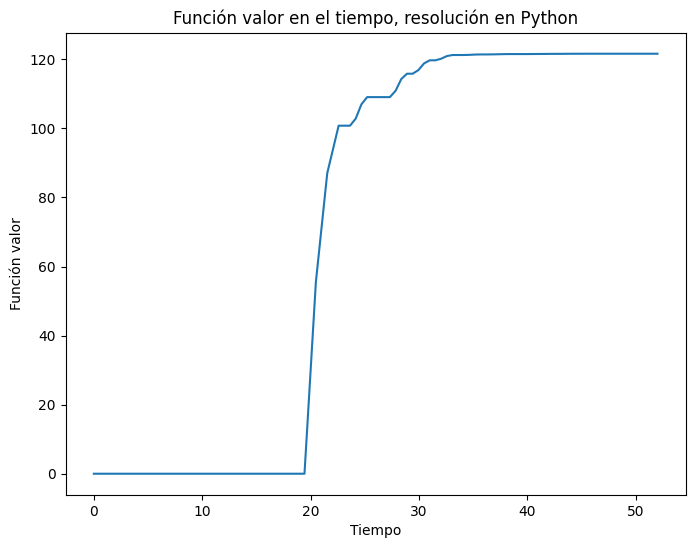

In [ ]:
# Entrega valor objetivo de Python para los pares óptimos (CA,CC,C) del problema de control en cada tiempo i
value_a = np.zeros_like(t_eval)
for i in range(nt-1): 
    value_a[i+1] = np.trapz(co_op[:i]*(CC[:i]*mc + CA[:i]*ma), t_eval[:i]) #Integra hasta el tiempo i

# Gráficos
plt.figure(figsize=(8, 6))
plt.plot(t_eval, value_a)
plt.xlabel("Tiempo")
plt.ylabel(r"Función valor")
plt.title("Función valor en el tiempo, resolución en Python")
plt.show()

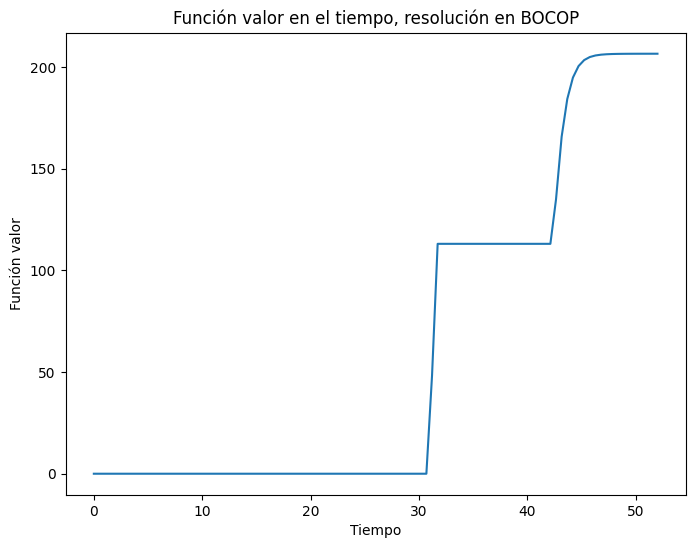

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(t_bocop, value_bocop)
plt.xlabel("Tiempo")
plt.ylabel(r"Función valor")
plt.title("Función valor en el tiempo, resolución en BOCOP")
plt.show()

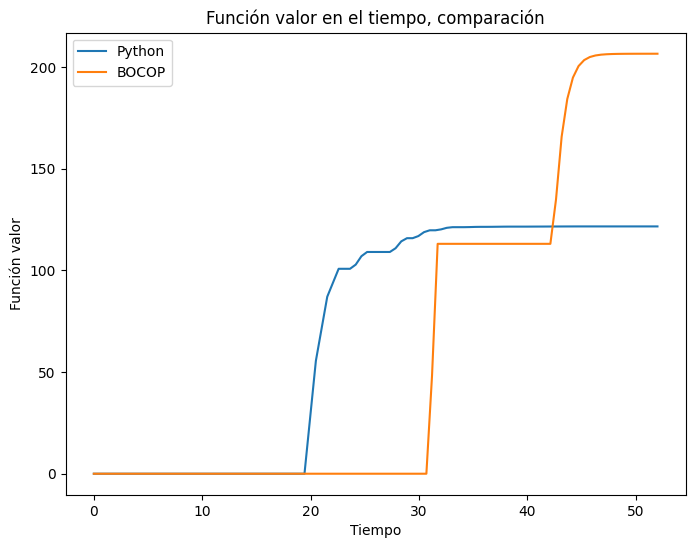

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(t_eval, value_a, label="Python")
plt.plot(t_bocop, value_bocop, label="BOCOP")
plt.xlabel("Tiempo")
plt.ylabel(r"Función valor")
plt.title("Función valor en el tiempo, comparación")
plt.legend()
plt.show()

In [ ]:
print("Camarones adultos", np.trapz(CA, t_eval))

Camarones adultos 87125.59305659044


Respecto de la preguntas 
* ¿Cuál de los controles utilizaría para resolver este problema en la vida real? ¿Por qué? 

**R**: En primer lugar, el control obtenido en BOCOP alcanza un mayor valor para la función objetivo que aquel obtenido por Python, con una diferencia notable, posiblemente se deba a errores númericos que se propagaron a partir de la solución de $(p_1(0),p_2(0))$ con el método de tiro, por lo que en principio se escoge la solución propuesta por BOCOP 

Por otro lado, observando la forma que tienen los controles, notamos que el control que muestra Python resulta poco practico en la vida real pues consiste en salir a pescar por cortos periodos de tiempo a maxima intensidad de manera muy frecuente, pasar de una intensidad de captura de $0$ a $C_{max}$ de manera frecuente durante cortos periodos de tiempo se traduce en el mundo real al hecho de salir a terreno multiples veces, lo cual implica a su ves gastos extras que afectan la utilidad real asociada al problema.

A diferencia de este comportamiento entregado de la solución de Python, el control que propone BOCOP es salir a pescar un corto periodo de tiempo, esperar, y luego pescar durante un largo periodo hasta que se acaben los camarones, que se traduce en dos salidas a terreno intensas, que abaratan a su vez los costos.

* ¿Y si fuera otro problema, bajo qué criterios escogería uno o el otro?

**R**: Los criterios que se considerarían para otro problema de naturaleza similar, sería tomar en cuenta el valor que toman las funciones objetivos, y además considerar los gastos que implica la estructura del control, pues dependiendo de la situación, un control de tipo Bang-Bang que se activa reiteradas veces durante cortos periodos de tiempo podría no ser implementado, como es el caso en que el control significa la intensidad de captura.

### Parte B. Ecuaciones de Hamilton-Jacobi-Bellman

Consideremos el siguiente sistema dinámico controlado no lineal:

$$
\min J(u(\cdot))=\int_0^1(x(t) u(t))^2 d t+x(1)^2 ; \quad \text { s.a. } \quad \dot{x}(t)=-x(t) u(t), \quad x(0)=1 .
$$

Asumiremos que la solución a la ecuación de HJB asociada al problema es cuadrática, i.e.
$$
V(t, x)=a(t) x^2+b(t) x+c(t)
$$
para ciertas funciones $a, b, c: \mathbb{R}_{+} \rightarrow \mathbb{R}$.

#### Ejercicio 7

Se escribe la ecuación de HJB del problema, reemplazando V (t, x) por el presentado antes.

El Hamiltoniano asociado al problema se escribe como

$$
H(x,u,p) = x^{2} u^{2} - pxu
$$

Y la ecuación de HJB para la función valor del problema $V(\cdot)$ se escribe tomando $\lambda = 0 , g(e[x]) = x(t_f)^{2}$ como

$$
\frac{\partial V}{\partial t} + inf_{u \in \mathbb{R}} H(x,u,\frac{\partial V}{\partial x}) = 0
$$

$$
V(T,x) = x^{2}
$$

$$
\frac{\partial V}{\partial t} + inf_{u \in \mathbb{R}} [x^{2}u^{2} - \frac{\partial V}{\partial x}xu] = 0 
$$

$$
V(T,x) = x^{2}
$$

Notamos que la expresión 

$$
inf_{u \in \mathbb{R}} [x^{2}u^{2} - \frac{\partial V}{\partial x}xu]
$$

Es convexa como función de $u$, pues es suma de una parte convexa $(x^{2}u^{2})$ con una parte lineal $(\frac{\partial V}{\partial x} x u)$, luego, derivando con respecto de $u$ e igualando a 0 se encuentra el $u$ que realiza el ínfimo

$$
\implies 2 u x^{2} - \frac{\partial V}{\partial x}x = 0
$$

$$
\implies u = \frac{\partial V}{\partial x} \frac{1}{2x}
$$

Reemplazando entonces dicho $u$ en el verdadero Hamiltoniano se obtiene

$$
inf_{u \in \mathbb{R}} [x^{2}u^{2} - \frac{\partial V}{\partial x}xu] = x^{2}(\frac{\partial V}{\partial x})^{2} \frac{1}{4x^{2}} - \frac{\partial V}{\partial x} \frac{\partial V}{\partial x} \frac{x}{2x} 
$$

Luego, la ecuación de HJB se alcanza se ve como

$$
\frac{\partial V}{\partial t} + \frac{1}{4}(\frac{\partial V}{\partial x})^{2} - \frac{1}{2}(\frac{\partial V}{\partial x})^{2} = 0
$$

Equivalentemente se tiene 
$$
\frac{\partial V}{\partial t} - \frac{1}{4}(\frac{\partial V}{\partial x})^{2} = 0
$$
 
$$
V(T,x) = x^{2}
$$



Suponiendo que $V(\cdot)$ es de la forma 

$$
V(t, x)=a(t) x^2+b(t) x+c(t)
$$

Tenemos de la condición de término

$$
V(T,x) = a(T)x^{2} + b(T)x +c(T) = x^{2}
$$
$$
\implies a(T) = 1 \ , b(T) = 0, c(T) = 0
$$

Computando $\frac{\partial V}{\partial t}$ y $\frac{\partial V}{\partial x}$ para $V(\cdot)$ con la forma anterior.

$$
\frac{\partial V}{\partial t} = a'(t) x^{2} + b'(t) x + c'(t)
\ , \ 
\frac{\partial V}{\partial x} = 2a(t) x + b(t) 
$$

$$
\implies (\frac{\partial V}{\partial x})^{2} = 4 a(t)^{2} x^{2} + 4a(t)b(t) x + b(t)^{2}
$$
Del desarrollo anterior tenemos que $V(\cdot)$ cumple la ecuación diferencial
$$
4a'(t) x^{2} + 4b'(t) x + 4c'(t) = 4 a(t)^{2} x^{2} + 4a(t)b(t) x + b(t)^{2} \ \ \forall t \in [0,t_f] \ \  \forall x \in \mathbb{R}
$$

De donde se deduce que las funciones $a(t), b(t) ,c(t)$ deben cumplir la ecuación diferencial junto a las condiciones de término antes obtenidas
$$
\begin{cases}
a'(t) = a(t)^{2} \ , \ a(T) = 1 \\

b'(t) = a(t)b(t) \ , \ b(T) = 0 \\

c'(t) = \frac{b(t)^{2}}{4} \ , \ c(T) = 0
\end{cases}
$$

Consideramos entonces las funciones asociadas a la dinámica inversa

$$
\hat{a}(t) = a(T-t) \ , \  \hat{b}(t) = b(T-t) \ , \  \hat{c}(t) = c(T-t) \ , \  
$$

Se tiene que la dinámica inversa cumple la ecuación diferencial con condiciones iniciales

$$
\begin{cases}
\hat{a}'(t) = -a(t)^{2} \ , \ \hat{a}(0) = 1 \\

\hat{b}'(t) = -a(t)b(t) \ , \ \hat{b}(0) = 0 \\

\hat{c}'(t) = -\frac{b(t)^{2}}{4} \ , \ \hat{c}(0) = 0
\end{cases}
$$

Se utiliza el método $\textit{solve ivp}$ para resolver la ecuación y a partir de las soluciones de $(\hat{a}(t), \hat{b}(t), \hat{c}(t))$ encontrar las funciones $(a(t),b(t),c(t))$


In [ ]:
# Inicialización
x0 = 1
T = 1
nt = 100
t_eval_b = np.linspace(0, T, nt) 
a0, b0, c0 = 1, 0, 0

# Dinámica del sistema inverso
def F2(t, X):
    a, b, c = X  

    da = -a**2
    db = -a*b 
    dc = -(b**2)/4 

    return np.array([da, db, dc])

res2 = solve_ivp(F2, (0,1), np.array([a0, b0, c0]), t_eval=t_eval_b)

# Entrega solución del sistema inverso
a_til, b_til, c_til = res2['y']

a_t, b_t, c_t = interp1d(t_eval_b, a_til), interp1d(t_eval_b, b_til), interp1d(t_eval_b, c_til)

# Entrega funciones a(t), b(t) y c(t) a partir del sistema inverso
a_fun, b_fun, c_fun = lambda t: a_t(T-t), lambda t: b_t(T-t), lambda t: c_t(T-t)

# Entrega función valor a partir de las funciones (a(t), b(t), c(t))
V = lambda t, x: a_fun(t)*x**2 + b_fun(t)*x + c_fun(t)
Vx = lambda t, x: 2*a_fun(t)*x + b_fun(t)

# Definición de Gamma
Gamma = lambda x, p: p/(2*x)

#### Ejercicio 8

Se implementa la función tipo feedback que entregue el valor del control óptimo
$$
u^*(\cdot)=\Gamma(x(\cdot), \partial x V(\cdot, x(\cdot)))
$$
donde $\Gamma(x, p):=\operatorname{argmin}_{w \in U}\{H(t, x, w, p)\}$. 
Puesto que 
$$
H(x,u,p) = x^{2} u^{2} - pxu
$$
Entonces tenemos que $\Gamma$ se escribe como
$$
\Gamma(x, p):=\operatorname{argmin}_{w} \{x^{2} w^{2} - pxw\}
$$
Y como $H(x,w,p)$ es convexa para $w$, se tiene que el único valor de $w$ que alcanza el mínimo satisface
$$
2x^{2} w - px = 0 \ \implies w = \frac{p}{2x}
$$
Por lo tanto
$$
\Gamma(x,p) = \frac{p}{2x}
$$

In [ ]:
# Dinámica de la función de estado como feedback
def F_opt(t, x):
    return -x*Gamma(x, Vx(t, x))

res_opt = solve_ivp(F_opt, (0,1), y0=np.array([x0]), t_eval=t_eval_b)

# Solución óptima para trayectoria
x_arr = res_opt["y"] 

# Entrega trayectoria óptima interpolada
x_opt = interp1d(t_eval_b, x_arr) 

# Construye el control óptimo 
u_opt = lambda t: Gamma(x_opt(t), Vx(t, x_opt(t)))

x, u = x_opt(t_eval_b).reshape(len(t_eval_b)), u_opt(t_eval_b).reshape(len(t_eval_b))

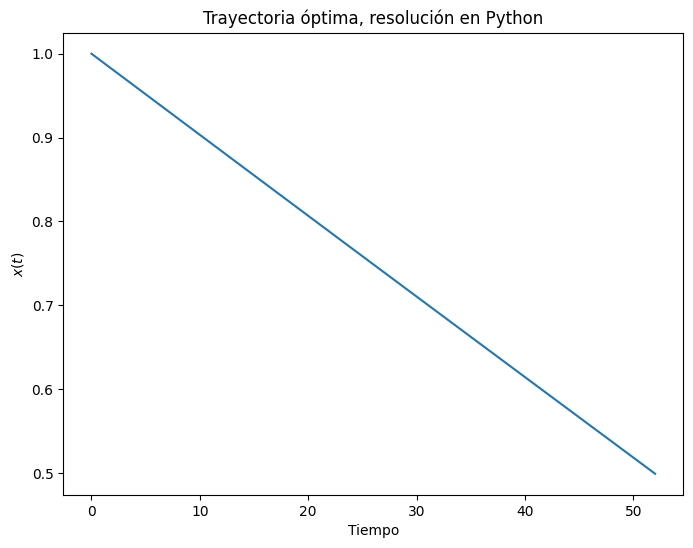

In [ ]:
# Gráficos
plt.figure(figsize=(8, 6))
plt.plot(t_eval, x, label="Trayectoria")

plt.xlabel("Tiempo")
plt.ylabel(r"$x(t)$")

plt.title("Trayectoria óptima, resolución en Python")
plt.show()

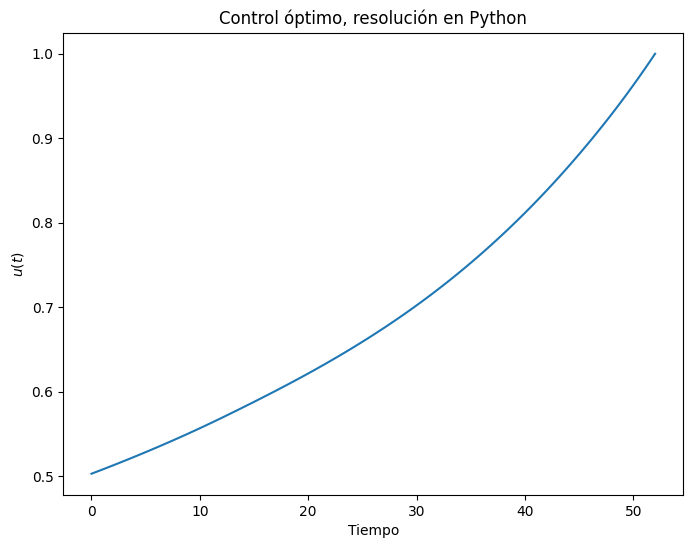

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(t_eval, u, label="Control óptimo")

plt.xlabel("Tiempo")
plt.ylabel(r"$u(t)$")

plt.title("Control óptimo, resolución en Python")
plt.show()

#### Ejercicio 9

Se resuelve el problema en BOCOP y se comparan los resultados 


Nuevamente se convertirá al problema en uno puramente Mayer llamando
$$

    z(t) = \int_0^t (x(s) u(s))^2 ds

$$
Que satisface el problema
$$
    \dot z(t) = (x(t) u(t))^2; \quad z(0) = 0 
$$
Ahora el problema se escribe
$$
\min J(u(\cdot))=z(1)+x(1)^2 ; \quad \text { s.a. } \quad \dot{x}(t)=-x(t) u(t), \, \dot z(t) = (x(t) u(t))^2 \,  \quad x(0)=1, \, z(0) = 0 .
$$
Que ahora es resoluble en BOCOP, con lo que se utilizan 100 pasos temporales y el método Gauss II (implícito, 2 etapas, orden 4). Los gráficos obtenidos se dejan en el ejercicio siguiente como comparativa con lo obtenido con Python.

**Importe**

In [ ]:
x_bocop = np.array([
        1,
    0.995,
    0.99,
    0.985,
    0.98,
    0.975,
    0.97,
    0.965,
    0.96,
    0.955,
    0.95,
    0.945,
    0.94,
    0.935,
    0.93,
    0.925,
    0.92,
    0.915,
    0.91,
    0.905,
    0.9,
    0.895,
    0.89,
    0.885,
    0.88,
    0.875,
    0.87,
    0.865,
    0.86,
    0.855,
    0.85,
    0.845,
    0.84,
    0.835,
    0.83,
    0.825,
    0.82,
    0.815,
    0.81,
    0.805,
    0.8,
    0.795,
    0.79,
    0.785,
    0.78,
    0.775,
    0.77,
    0.765,
    0.76,
    0.755,
    0.75,
    0.745,
    0.74,
    0.735,
    0.73,
    0.725,
    0.72,
    0.715,
    0.71,
    0.705,
    0.7,
    0.695,
    0.69,
    0.685,
    0.68,
    0.675,
    0.67,
    0.665,
    0.66,
    0.655,
    0.65,
    0.645,
    0.64,
    0.635,
    0.63,
    0.625,
    0.62,
    0.615,
    0.61,
    0.605,
    0.6,
    0.595,
    0.59,
    0.585,
    0.58,
    0.575,
    0.57,
    0.565,
    0.56,
    0.555,
    0.55,
    0.545,
    0.54,
    0.535,
    0.53,
    0.525,
    0.52,
    0.515,
    0.51,
    0.505,
    0.5
])

In [ ]:
u_bocop = np.array([
    0.501254,
    0.503779,
    0.50633,
    0.508907,
    0.51151,
    0.51414,
    0.516797,
    0.519482,
    0.522194,
    0.524936,
    0.527706,
    0.530505,
    0.533335,
    0.536194,
    0.539085,
    0.542007,
    0.54496,
    0.547947,
    0.550966,
    0.554018,
    0.557105,
    0.560226,
    0.563382,
    0.566574,
    0.569802,
    0.573067,
    0.57637,
    0.579712,
    0.583092,
    0.586512,
    0.589972,
    0.593474,
    0.597017,
    0.600602,
    0.604231,
    0.607905,
    0.611623,
    0.615387,
    0.619197,
    0.623055,
    0.626961,
    0.630917,
    0.634923,
    0.63898,
    0.643089,
    0.647251,
    0.651468,
    0.65574,
    0.660068,
    0.664454,
    0.668899,
    0.673403,
    0.677969,
    0.682597,
    0.687288,
    0.692044,
    0.696867,
    0.701757,
    0.706717,
    0.711747,
    0.716849,
    0.722025,
    0.727276,
    0.732604,
    0.738011,
    0.743498,
    0.749067,
    0.754721,
    0.76046,
    0.766287,
    0.772205,
    0.778214,
    0.784318,
    0.790518,
    0.796817,
    0.803217,
    0.809721,
    0.816331,
    0.82305,
    0.82988,
    0.836825,
    0.843887,
    0.851069,
    0.858374,
    0.865806,
    0.873368,
    0.881063,
    0.888895,
    0.896867,
    0.904984,
    0.913248,
    0.921666,
    0.930239,
    0.938974,
    0.947874,
    0.956945,
    0.966191,
    0.975617,
    0.98523,
    0.995033,
    0.995033
])

In [ ]:
z_bocop = np.array([
    9.82485e-042,
    0.0025,
    0.005,
    0.0075,
    0.01,
    0.0125,
    0.015,
    0.0175,
    0.02,
    0.0225,
    0.025,
    0.0275,
    0.03,
    0.0325,
    0.035,
    0.0375,
    0.04,
    0.0425,
    0.045,
    0.0475,
    0.05,
    0.0525,
    0.055,
    0.0575,
    0.06,
    0.0625,
    0.065,
    0.0675,
    0.07,
    0.0725,
    0.075,
    0.0775,
    0.08,
    0.0825,
    0.085,
    0.0875,
    0.09,
    0.0925,
    0.095,
    0.0975,
    0.1,
    0.1025,
    0.105,
    0.1075,
    0.11,
    0.1125,
    0.115,
    0.1175,
    0.12,
    0.1225,
    0.125,
    0.1275,
    0.13,
    0.1325,
    0.135,
    0.1375,
    0.14,
    0.1425,
    0.145,
    0.1475,
    0.15,
    0.1525,
    0.155,
    0.1575,
    0.16,
    0.1625,
    0.165,
    0.1675,
    0.17,
    0.1725,
    0.175,
    0.1775,
    0.18,
    0.1825,
    0.185,
    0.1875,
    0.19,
    0.1925,
    0.195,
    0.1975,
    0.2,
    0.2025,
    0.205,
    0.2075,
    0.21,
    0.2125,
    0.215,
    0.2175,
    0.22,
    0.2225,
    0.225,
    0.2275,
    0.23,
    0.2325,
    0.235,
    0.2375,
    0.24,
    0.2425,
    0.245,
    0.2475,
    0.25
])

In [ ]:
t_bocop_b = np.linspace(0, 1, len(x_bocop))

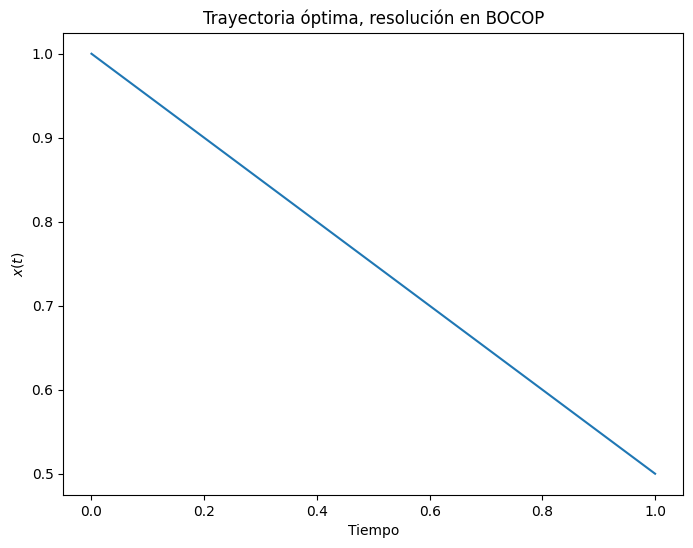

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(t_bocop_b, x_bocop, label="Trayectoria")

plt.xlabel("Tiempo")
plt.ylabel(r"$x(t)$")

plt.title("Trayectoria óptima, resolución en BOCOP")
plt.show()

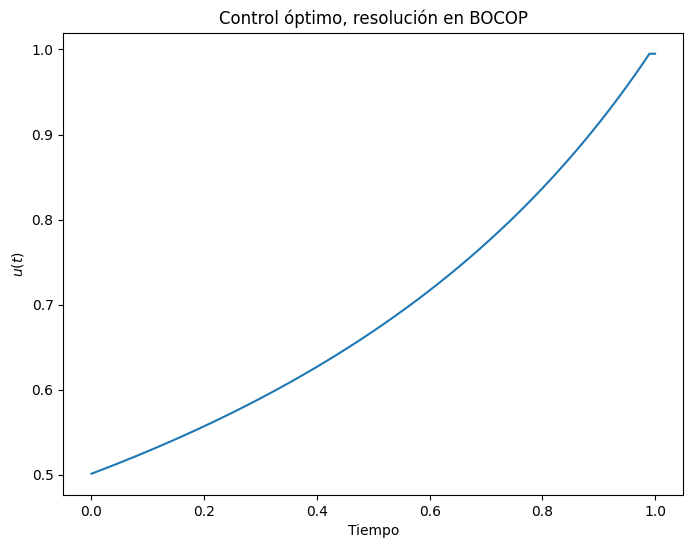

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(t_bocop_b, u_bocop)

plt.xlabel("Tiempo")
plt.ylabel(r"$u(t)$")

plt.title("Control óptimo, resolución en BOCOP")
plt.show()

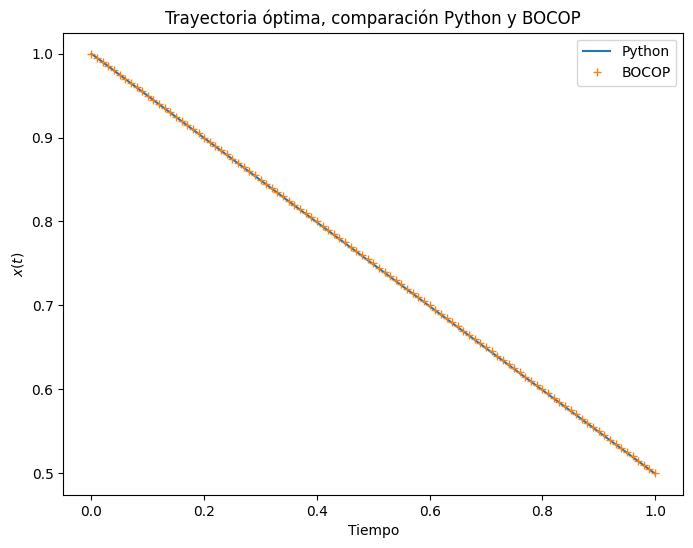

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(t_eval_b, x, label="Python")
plt.plot(t_bocop_b, x_bocop, "+", label="BOCOP")

plt.xlabel("Tiempo")
plt.ylabel(r"$x(t)$")

plt.legend()
plt.title("Trayectoria óptima, comparación Python y BOCOP")
plt.show()

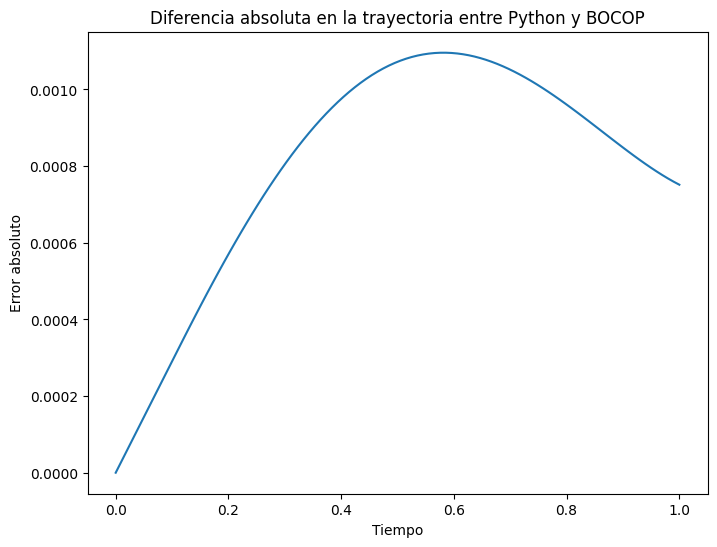

In [ ]:
x_py_int = interp1d(t_eval_b, x)
x_boc_int = interp1d(t_bocop_b, x_bocop)

error_b_x = np.abs(x_py_int(t_eval_b) - x_boc_int(t_eval_b)) 

plt.figure(figsize=(8, 6))
plt.plot(t_eval_b, error_b_x)
plt.xlabel("Tiempo")
plt.ylabel(r"Error absoluto")
plt.title("Diferencia absoluta en la trayectoria entre Python y BOCOP")
plt.show()

In [ ]:
print("Errores absoluto total:")
print("x:", np.sum(error_b_x))

Errores absoluto total:
x: 0.08030295194547654


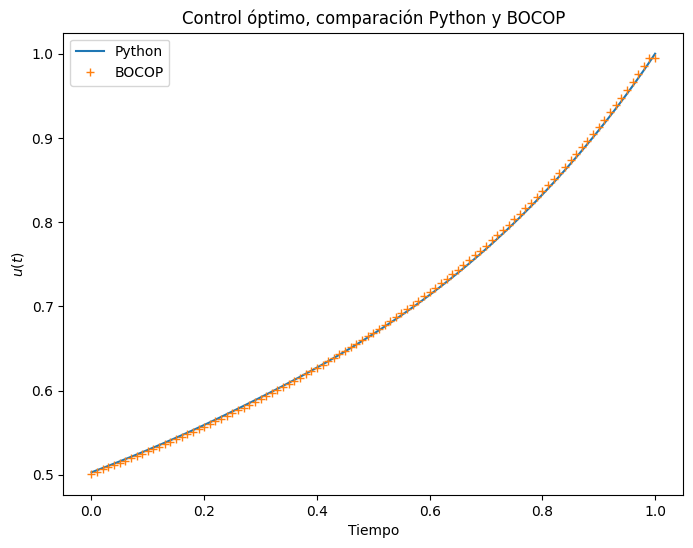

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(t_eval_b, u, label="Python")
plt.plot(t_bocop_b, u_bocop, "+", label="BOCOP")

plt.xlabel("Tiempo")
plt.ylabel(r"$u(t)$")

plt.legend()
plt.title("Control óptimo, comparación Python y BOCOP")
plt.show()

In [ ]:
value_b = np.zeros_like(t_eval_b)

h = t_eval_b[1] - t_eval_b[0]

for i in range(len(value_b)): 
    value_b[i] = np.trapz(x[:i]**2*u[:i]**2, t_eval_b[:i]) + x[i]**2

In [ ]:
value_bocop_b = z_bocop + x_bocop**2

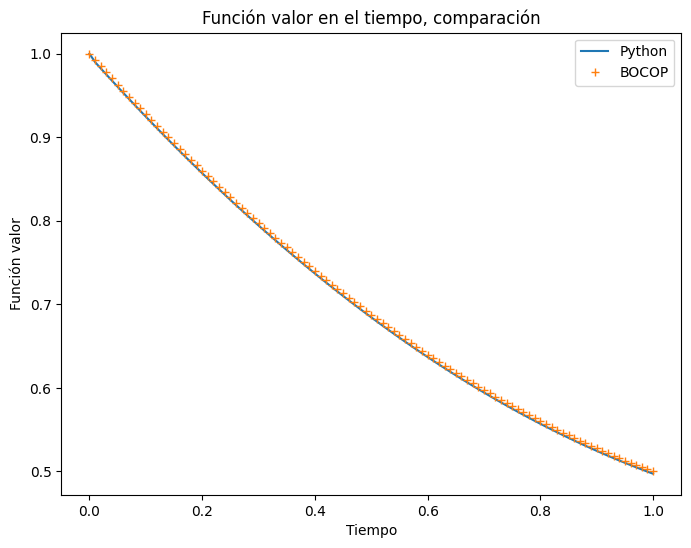

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(t_eval_b, value_b, label="Python")
plt.plot(t_bocop_b, value_bocop_b, "+", label="BOCOP")
plt.xlabel("Tiempo")
plt.ylabel(r"Función valor")
plt.title("Función valor en el tiempo, comparación")
plt.legend()
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=abcef1e8-e518-4256-bc64-52d9d958f433' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>